# Galvanometer Scanner and Dual Triggering

## Introduction

Code to generate the scanning mirror analog voltage signal, and digital triggers for synchronized camera triggering for simulaneous PIV (particle image velocimetry) and PLIF (planar laser induced fluorescence). This code requires 
- MATLAB
- DAQ with analog and digital outputs
- galvanometer scanner that can be controlled by an analog signal
- two cameras that can be externally triggered

and will generate two laser sweeps for the image. During the first sweep the PIV image is captured, and during the second sweep, both PIV and PLIF images are captured. 

## Setting up the DAQ and Measurement Parameters

First identify the DAQ to be used 

```matlab
d = daqlist;
d{1, "DeviceInfo"}
dq = daq("ni");

addoutput(dq, "Dev1", "ao1", "Voltage");
ctr=addoutput(dq,"Dev1","ctr0","PulseGeneration");
```

Specify parameters for the lightsheet duration, exposure time, frequency and starting and end angles of the sheet.

In [2]:
PLIF_fps=7.5; % hz, frequency of the PLIF
PLIF_Tint=8; % ms, light sheet duration
PLIF_EXE=63; % ms, as determined by the camera
dt=1.5; % ms, between PIV signals

PLIF_right=-20; % deg, on the right
PLIF_left=15;   % deg, on the left
PLIF_A=2;       % the laser will "rest" at a location offset by this value
Tpost=2; % post sweep delay [ms] typically small (2ms)

%% total number of images 
nimg=7.5*500;

The signal is then built according the form given in
>Crimaldi, J., Koseff, J. High-resolution measurements of the spatial and temporal scalar structure of a turbulent plume. _Experiments in Fluids_ **31**, 90–102 (2001). https://doi.org/10.1007/s003480000263

In [2]:
%% start building the signal

PLIF_NLEN=12000; % number of signals per cycle
sps=PLIF_NLEN*PLIF_fps; %full number of signals

PLIF_N=PLIF_Tint/1000*sps; %signals per light sheet
i=1:PLIF_N; % length of mirror signal, dictated

VPD=20/60; %volts/deg
%%%compose PLIF mirror signal
PLIF_A_tot=PLIF_right-PLIF_left+2*PLIF_A;
PLIF_M=(atan(((i-PLIF_N/2)/(PLIF_N-1))*2*tan(pi*PLIF_A_tot*.5/180))*180+(PLIF_right+PLIF_left))*VPD/pi;
[rm ri]=min(abs(PLIF_M/VPD-PLIF_right));
[lm li]=min(abs(PLIF_M/VPD-PLIF_left));

%%%convert dt to #of signals
N_dt=floor(dt*.001*sps);
N_Tpost=floor(Tpost*.001*sps);
N_PIV_exp=floor(PLIF_Tint*.001*sps);

% PLIF_NLEN is signals per period defined by PLIF_fps
i_mid=floor(0.5*PLIF_NLEN); % this index the start of the second image/end of first
%offset=200;
offset=-20;

% define start and end points in time
im1_start=1;     im1_end=floor(PLIF_EXE/1e3*sps); 
im2_start=i_mid; im2_end=i_mid+floor(PLIF_EXE/1e3*sps);

piv1_end=im1_end-offset;
piv1_start=piv1_end-PLIF_N+1;

piv2_start=piv1_end+N_dt;
piv2_end=piv2_start+PLIF_N-1;

% msig is the signal sent to the galvo
msig=ones(1,PLIF_NLEN)*(min(PLIF_M)-2.0);
msig(piv1_start:piv1_end)=PLIF_M;
msig(piv2_start:piv2_end)=PLIF_M;
 
SL=length(msig); % signal length

fprintf('min PLIF exposure time \t = %5.3f (ms) \n',(piv1_end-piv1_start)/sps*1e3);
fprintf('min PIV exposure time \t = %5.3f (ms) \n',PLIF_EXE);
fprintf('number of cycles per second \t = %2.2f (Hz) \n',sps/SL);
fprintf('dt between images \t = %2.2f (ms)\n',(piv2_start-piv1_end)/sps*1e3);

min PLIF exposure time 	 = 7.989 (ms) 
min PIV exposure time 	 = 63.000 (ms) 
number of cycles per second 	 = 7.50 (Hz) 
dt between images 	 = 1.50 (ms)


To illustrate the timings for the cameras, we can also build the signal of the counter, although is this really automated by the pulse generator built into the DAQ.

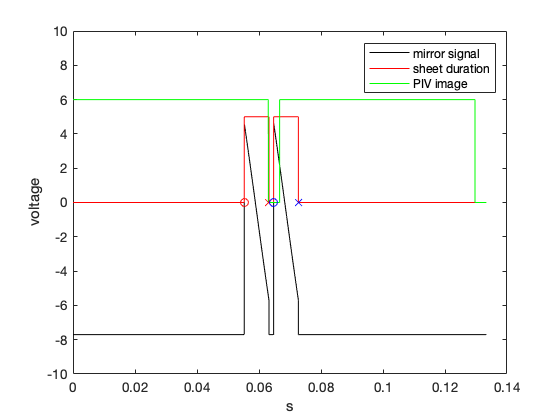

In [3]:
%% csig and imsg are just generated for the plots, and not sent to the daq
csig=msig*0;
toff=0;
cv=5; % voltage for the counter to be plotted at
ioff=0;

csig(ioff+piv1_start:ioff+piv1_end-toff)=cv;
csig(ioff+piv2_start:ioff+piv2_end-toff)=cv;

imsg=msig*0;
imsg(im1_start:im1_end)=cv+1;
imsg(im2_start:im2_end)=cv+1;

showplot=1;
if(showplot)
    p(1)=plot((1:length(msig))/sps,msig,'k'); %MIRROR SIGNAL
    hold on;
    p(2)=plot((1:length(msig))/sps,csig,'r'); % sheet duration
    p(3)=plot((1:length(msig))/sps,imsg,'g'); %
    
    hold on
    plot(piv1_start/sps,0,'or');
    plot(piv1_end/sps,0,'xr');
    
    plot(piv2_start/sps,0,'ob');
    plot(piv2_end/sps,0,'xb');
    ylim([-10 10]);
    
    ylabel('voltage');
    xlabel('s');
    legend(p,{'mirror signal','sheet duration','PIV image'});
    
end

Notice that the signal is centered at t=1/15=66.67 miliseconds. The cameras are essentially always triggered at 15 Hz, and the light sweeps are made at the end of one image, and the beginning of the next. The PIV camera settings should be aligned with the green boxes, and the PLIF camera should be set to record only the second sweep. These settings will maximize the brightness of the images.

## Output to DAQ

If the plot of the signals look good, then replicate the signal `msig` by nimg, and load the analog and digital signals onto the daq. The signal of the counter should be meausred by an oscilloscope to ensure the frequency of the pulses.

In [ ]:
%% Prepare the signal for the DAQ

% if the signal needs offsetting, use nz
nz=0;

S(1,1:length(msig))=msig;
output= [ones(1,nz)*(min(PLIF_M)-2) repmat(S,1,nimg)]';
dq.Rate = sps; % adjust DAQ rate based on signal length

% the CTR HAS AN OFFSET OF 0.01515 Hz for some reason
ctr.Frequency=PLIF_fps*2+0.015015;
toff=0;
ctr.InitialDelay=toff/1e3;
ctr.DutyCycle=0.1;

When ready, flush the DAQ, preload the signal, and wait for a keyboard input to trigger the lightsheet and cameras.
```matlab
%load the signal to the DAQ, and await go signal
flush(dq)
preload(dq,output);
pause()
start(dq);
```